# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, transfering, and extending of HBR models. 

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import make_param
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import arviz as az

import pymc.math as math


# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=("transfer", "fit")
)

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

In [3]:
save_dir = "resources/hbr/save_dir"
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir=save_dir,
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a Normal likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. We also use the mapping_params to scale the mapping by a factor of 3, to avoid spikes in the resulting density. 

In [4]:
mu = make_param(
    name="mu",
    linear=True,
    # slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    slope=make_param(random=True),
    intercept=make_param(
        random=True,
        sigma=make_param(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_param(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_param(
    name="sigma",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_param(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

epsilon = make_param(
    name="epsilon",
    dist_name="Normal",
    dist_params=(0.0, 1.0),
)

delta = make_param(
    name="delta",
    dist_name="Normal",
    dist_params=(1.0, 1.0),
    mapping="softplus",
    mapping_params=(0.0, 2.0, 0.3),
)


# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=2048,
    tune=512,
    chains=4,
    pymc_cores=16,
    likelihood="SHASHb",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
    nuts_sampler="nutpie",
)

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [5]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [6]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

In [7]:
# predictions = norm_hbr.fit_predict(train, test)
norm_hbr.fit_predict(train, test)


Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


ValueError: sex_offset_slope_mu has 3 dims but 2 dim labels were provided.

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

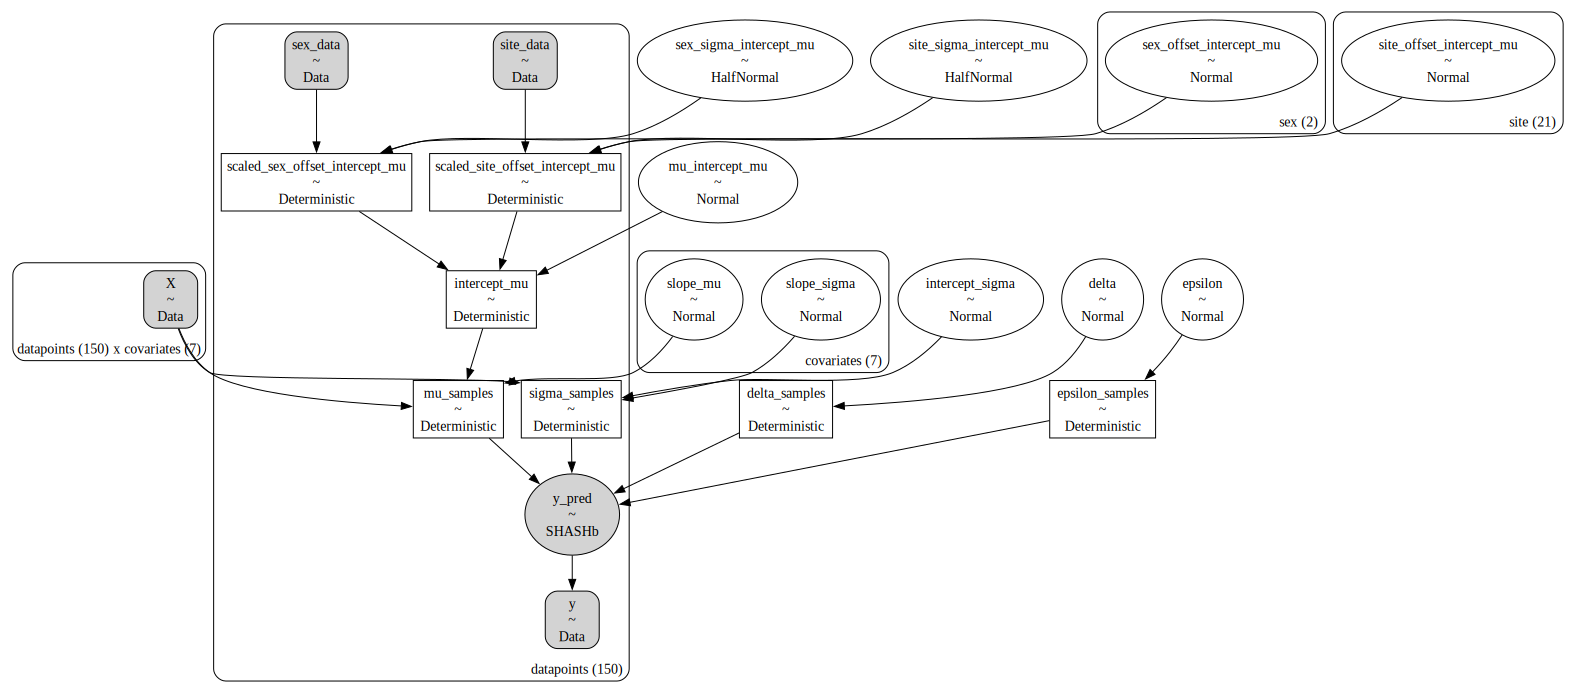

In [8]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


<Figure size 640x480 with 0 Axes>

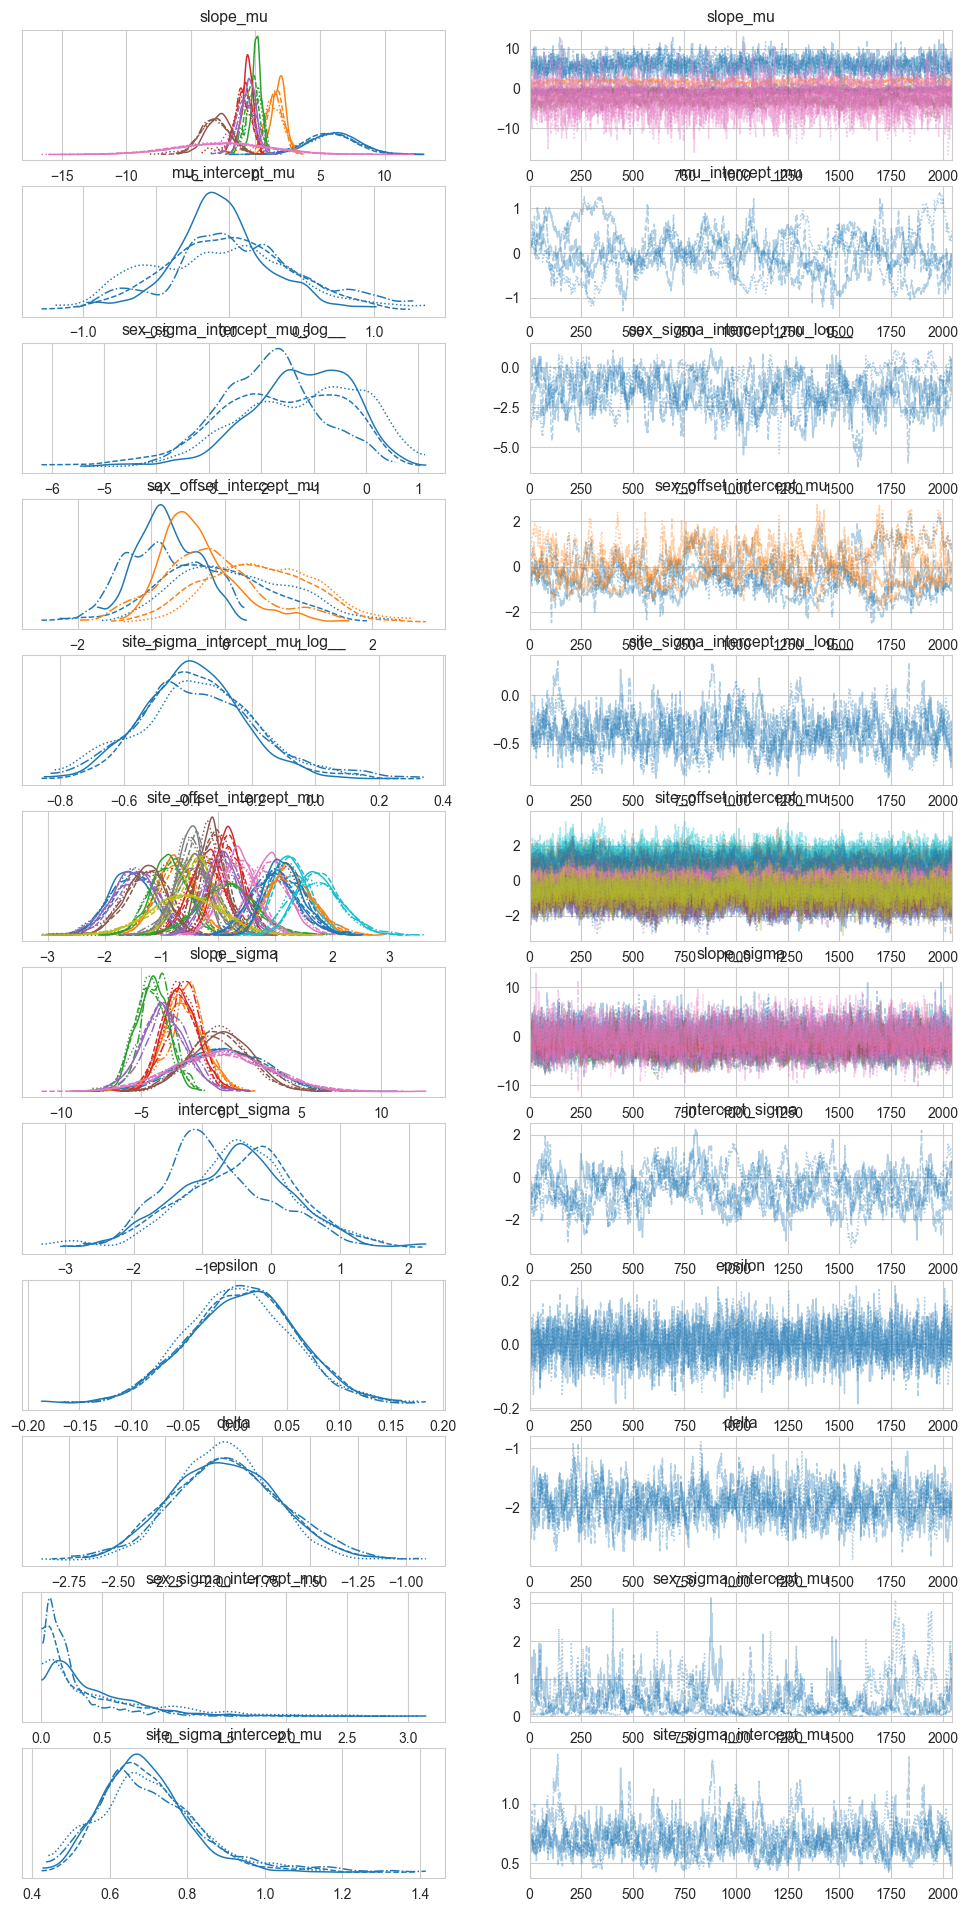

In [9]:
idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(
    idata.posterior,
    var_names=[
        "~mu_samples",
        "~sigma_samples",
        "~epsilon_samples",
        "~delta_samples",
        "~intercept_mu",
        "~scaled_site_offset_intercept_mu",
        "~scaled_sex_offset_intercept_mu",
    ],
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [10]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.557773,0.574712
RMSE,0.076124,527.780582
SMSE,0.648908,0.618908
ExpV,0.351288,0.444943
NLL,NaN,NaN
ShapiroW,0.990049,0.991019


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [11]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-0.659551,-0.330093
441,-0.309384,-0.414297
1029,1.322799,0.736930
64,-1.921201,0.366918
654,0.620911,-1.196765
...,...,...
611,-1.481959,1.672607
549,-1.548951,1.393328
640,-0.458568,-1.205989


In [12]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.381731         837.864643   
441                             2.374869         931.721158   
1029                            2.479923         558.341872   
64                              2.314447         558.375912   
654                             2.347297         355.593194   
...                                  ...                ...   
611                             2.357879         455.682436   
549                             2.233640         504.613217   
640                             2.293779         447.018979   
648                             2.373811         556.205852   
635                             2.486149         444.489001   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.455113        1031.589368   
441                             2.445386        1117.051567   
1029                            2.546906         738.106305   
64                              2.381882         737.116869   
654                             2.426587         777.136612   
...                                  ...                ...   
611                             2.437263         850.780050   
549                             2.312930         926.156635   
640                             2.381243        1132.949225   
648                             2.450954         833.494832   
635                             2.556666         629.819409   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.504292        1208.959742   
441                             2.492644        1286.742899   
1029                            2.591799         902.699557   
64                              2.427077         900.776311   
654                             2.479749        1163.033683   
...                                  ...                ...   
611                             2.490488        1212.449892   
549                             2.366092        1312.053707   
640                             2.439898        1761.021969   
648                             2.502669        1087.296946   
635                             2.603924         799.510742   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.553670        1492.882976   
441                             2.540098        1558.391632   
1029                            2.636884        1166.204322   
64                              2.472463        1162.785633   
654                             2.533144        1780.436835   
...                                  ...                ...   
611                             2.543943        1791.108379   
549                             2.419488        1929.456858   
640                             2.498827        2765.554492   
648                             2.554602        1493.456481   
635                             2.651378        1071.159474   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


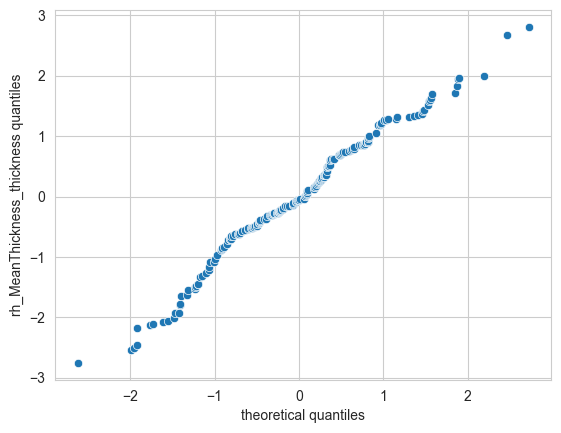

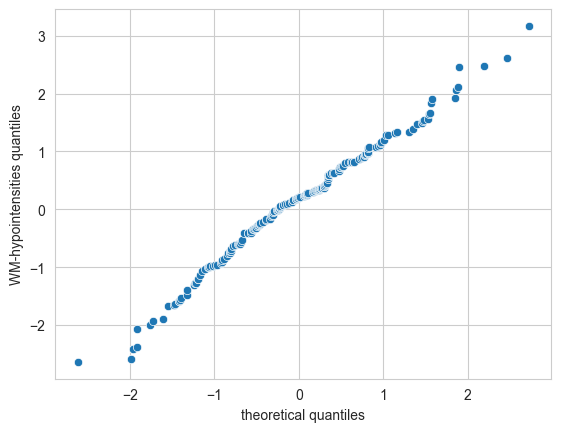

In [13]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


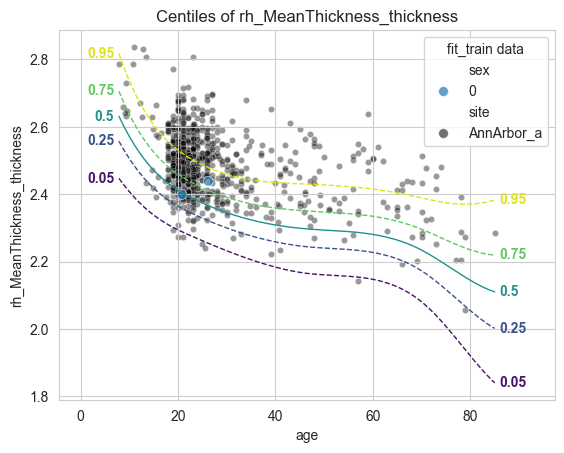

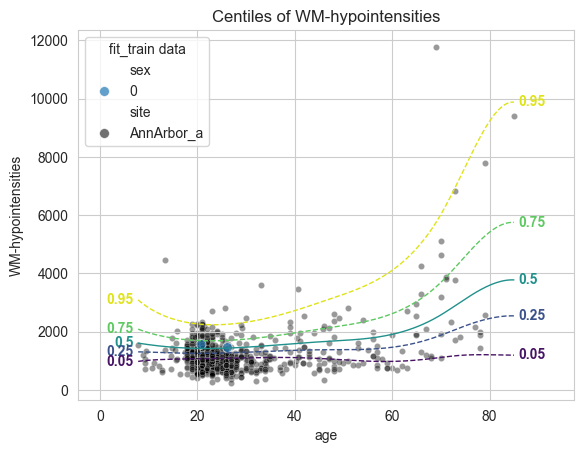

In [14]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


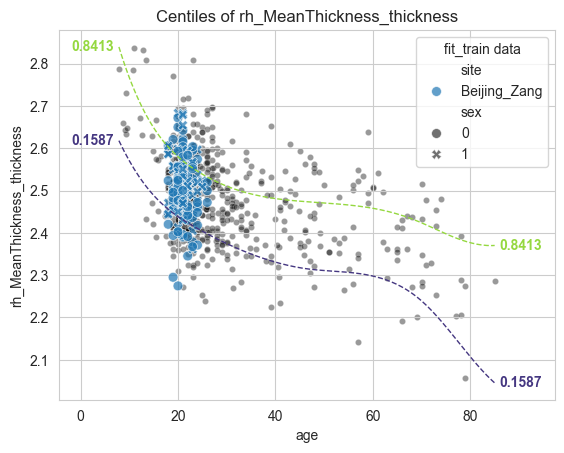

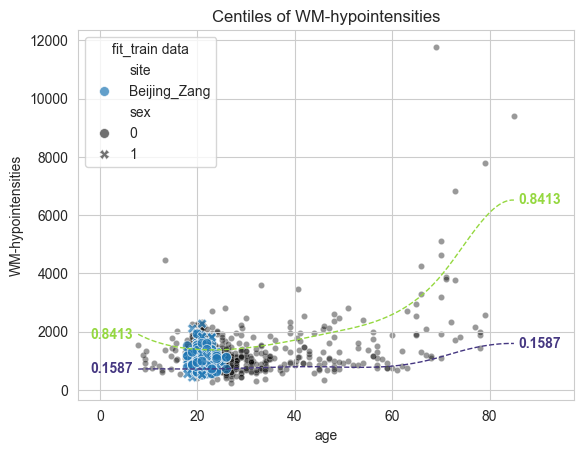

In [15]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

## Transfer

If we transfer to new dataset, we use the samples from the posterior to derive priors for a new model. That new model is then fitted on the new dataset. Our new model will not work on the old data. To give some extra control over the fit, we let the `freedom` parameter control the variance of the derived factorized posterior. Here we set it to something small (1e-4) to create a spike prior on the model parameters, to ensure that we do not 'forget' about what we learned from the original data. If we have a very large new dataset, we can set the freedom parameter to something bigger. 

In [16]:
from pcntoolkit.normative_model.norm_factory import load_normative_model

save_dir = "resources/hbr/save_dir"
model = load_normative_model(save_dir)

transfered_model = model.transfer_predict(
    transfer_train, transfer_test, freedom=1e-4, nuts_sampler="nutpie"
)

Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of normative model is valid.
Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2560,0,0.58,7
,2560,0,0.56,7
,2560,0,0.54,7
,2560,0,0.55,7


Transferring model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2560,0,0.58,7
,2560,0,0.50,7
,2560,0,0.53,7
,2560,0,0.50,7


Sampling: [y_pred]


Output()

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities


Sampling: [y_pred]
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/plots


In [17]:
transfered_model.predict(transfer_test)

Sampling: [y_pred]


Output()

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/plots


<xarray.NormData> Size: 13kB
Dimensions:            (datapoints: 30, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 7, cdf: 5,
                        statistics: 6)
Coordinates:
  * datapoints         (datapoints) int64 240B 951 953 915 943 ... 973 908 976
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U13 364B 'age_bspline_0' ... 'age_b...
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistics         (statistics) <U8 192B 'Rho' 'RMSE' ... 'NLL' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 240B 21.0 22.0 ... 21.0
    y                  (datapoints, response_vars) float64 480B 2.482 ... 646.6
    batch_effects      (datapoints, batch_effect_dims) <U11 3kB '0' ... 'Oulu'
    scaled_X           (datapoints, covariates) float64 240B -0.5173 ... -0.5173
    scaled_y           (datapoints, response_vars) float64 480B -0.01111 ... ...
    Phi                (datapoints, basis_functions) float64 2kB 0.2081 ... 0.0
    zscores            (datapoints, response_vars) float64 480B -2.061 ... -1...
    scaled_centiles    (cdf, datapoints, response_vars) float64 2kB 0.4242 .....
    centiles           (cdf, datapoints, response_vars) float64 2kB 2.526 ......
    Yhat               (datapoints, response_vars) float64 480B 2.691 ... 1.0...
    S2                 (datapoints, response_vars) float64 480B 0.004427 ... ...
    measures           (response_vars, statistics) float64 96B 0.7553 ... 0.9598
Attributes:
    name:                  transfer_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['Milwaukee_b', 'Oulu']}
    batch_effects_counts:  {'sex': {'0': 96, '1': 52}, 'site': {'Milwaukee_b'...

We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path.

### Extend

Extending a model on new data amounts to generating synthetic data according to the learned distribution, merging that with the new data, and fitting a new model on that merged dataset. This enables true federated learning, because the original data does not need to be shipped with the model to extend it to a new dataset. 

Because this is an extended model, we can make predictions on all sites, even those that were only present in the original data. 

In [18]:
save_dir = "resources/hbr/save_dir"
from pcntoolkit.normative_model.norm_factory import load_normative_model

model = load_normative_model(save_dir)

extended_model = model.extend_predict(transfer_train, transfer_test)

Configuration of normative model is valid.
Configuration of normative model is valid.


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2560,0,0.00,1023
,2560,0,0.00,1023
,2560,0,0.00,1023
,2560,0,0.00,1023


Sampling: [y_pred]


Output()

Fitting and predicting model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2560,0,0.00,1023
,2560,0,0.00,1023
,2560,0,0.00,1023
,2560,0,0.00,1023


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/model
Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/plots


In [19]:
extended_model.predict(test)

Sampling: [y_pred]


Output()

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/plots


<xarray.NormData> Size: 86kB
Dimensions:            (datapoints: 186, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 7, cdf: 5,
                        statistics: 6)
Coordinates:
  * datapoints         (datapoints) int64 1kB 515 441 1029 64 ... 640 648 635
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U13 364B 'age_bspline_0' ... 'age_b...
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistics         (statistics) <U8 192B 'Rho' 'RMSE' ... 'NLL' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 1kB 18.0 20.0 ... 20.0
    y                  (datapoints, response_vars) float64 3kB 2.456 ... 460.3
    batch_effects      (datapoints, batch_effect_dims) <U17 25kB '0' ... 'ICBM'
    scaled_X           (datapoints, covariates) float64 1kB -1.185 ... -1.096
    scaled_y           (datapoints, response_vars) float64 3kB 0.1781 ... -0....
    Phi                (datapoints, basis_functions) float64 10kB 0.01428 ......
    zscores            (datapoints, response_vars) float64 3kB -0.7187 ... -1...
    scaled_centiles    (cdf, datapoints, response_vars) float64 15kB -1.014 ....
    centiles           (cdf, datapoints, response_vars) float64 15kB 2.274 .....
    Yhat               (datapoints, response_vars) float64 3kB 2.504 ... 799.5
    S2                 (datapoints, response_vars) float64 3kB 0.002419 ... 2...
    measures           (response_vars, statistics) float64 96B 0.5578 ... 0.991
Attributes:
    name:                  fit_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['AnnArbor_a', 'AnnArb...
    batch_effects_counts:  {'sex': {'0': 493, '1': 437}, 'site': {'AnnArbor_a...

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset
- Extend the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!